# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 12.10.2024

Мягкий дедлайн: 23:59MSK 27.10.2024

Жесткий дедлайн: 23:59MSK 31.10.2024

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [ ]:
!pip install folium

In [ ]:
import folium

m = folium.Map(location=(50.97178, 9.79418), zoom_start=15)

m

Если вы всё сделали правильно, то выше должна открыться карта

### 📌 **Памятка по дз2**

Обрабатывать данные можно любым способом (`polars`, `pandas`, `pyspark`, ...), который вам нравится и запускается в ноутбуке, и любой библиотекой для визуализации (`matplotlib`, `seaborn`, `plotly`, ...). Пользуйтесь на здоровье, но!

> Учтите, что `polars` всё ещё молодой и не все библиотеки его поддерживают. `sklearn` во многом уже работает, но на всякий случай не стесняйтесь пользоваться методами `pl.DataFrame.to_pandas()` или `pl.DataFrame.to_numpy()`    

> Впрочем, `pandas` тоже не лишён проблем. `sklearn` принимает `pd.DataFrame` почти везде, проблемы очень редки, но если вдруг возникнет какая-то беда с шейпами, или ещё какой-нибудь казус, а вы уверены, что всё правильно, пользуйтесь `pd.DataFrame.to_numpy()`. Это не всегда решает проблему, но часто помогает понять, что на самом деле не так. При желании можно передавать и `Iterable`, и sparse-матрицы

> Графики должны быть понятные, читаемые и пр. Консультируйтесь с памяткой из дз1 в задании на график

> Для воспроизводимости результатов не забывайте пользоваться `np.random.seed(...)`, при необходимости чистите мусор `gc.collect()`, лучше в каждой ячейке

> Все результаты должны быть получены в ноутбуке. На каждый **Вопрос** долен быть дан **Ответ** (письменно (в Markdown например) или кодом)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [ ]:
db = pd.read_csv('train.csv')

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [ ]:
db = db.drop(columns=['dropoff_datetime'])
db['pickup_datetime'] = pd.to_datetime(db['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

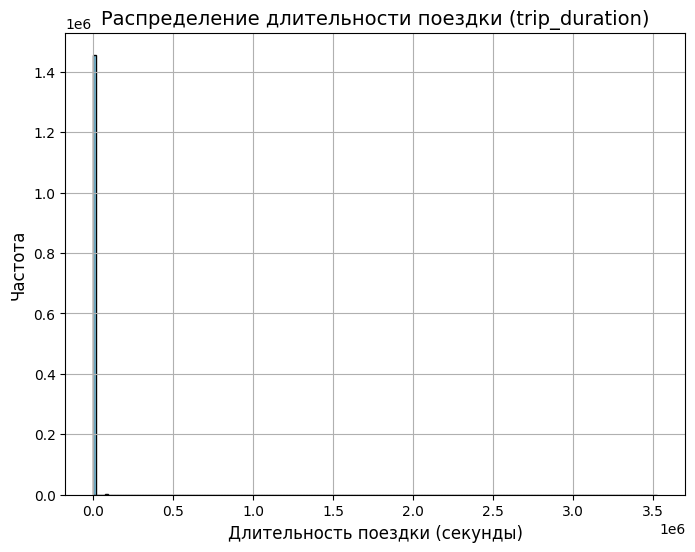

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(db['trip_duration'], bins=200, color='skyblue', edgecolor='black')
plt.title('Распределение длительности поездки (trip_duration)', fontsize=14)
plt.xlabel('Длительность поездки (секунды)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

- На графике видно, что большинство поездок имеют очень короткую продолжительность (примерно до 5000 секунд), тогда как существует небольшое количество поездок с крайне высокой длительностью.

- Длительные поездки могут быть выбросами.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**•	Логарифмическое преобразование сглаживает влияние выбросов. В реальных данных длительности поездок могут встречаться аномально длинные или короткие поездки (например, из-за пробок или задержек), которые могут сильно искажать результаты при использовании RMSE. RMSLE же делает модель менее чувствительной к таким выбросам.**

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**:


$\text{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(y_i + 1) - \log(\hat{y}_i + 1))^2}$

$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$


$\hat{y}_i = \exp(\hat{a}(x_i)) - 1$

Заменим  $\hat{y}_i$  в формуле RMSLE:


$\text{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\log(y_i + 1) - \log(\exp(\hat{a}(x_i)) - 1 + 1)\right)^2}$


$\text{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\log(y_i + 1) - \hat{a}(x_i)\right)^2}$

Теперь мы можем рассмотреть MSE для логарифмически преобразованных значений:

$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} ( \log(y_i + 1) - \hat{a}(x_i) )^2$


Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

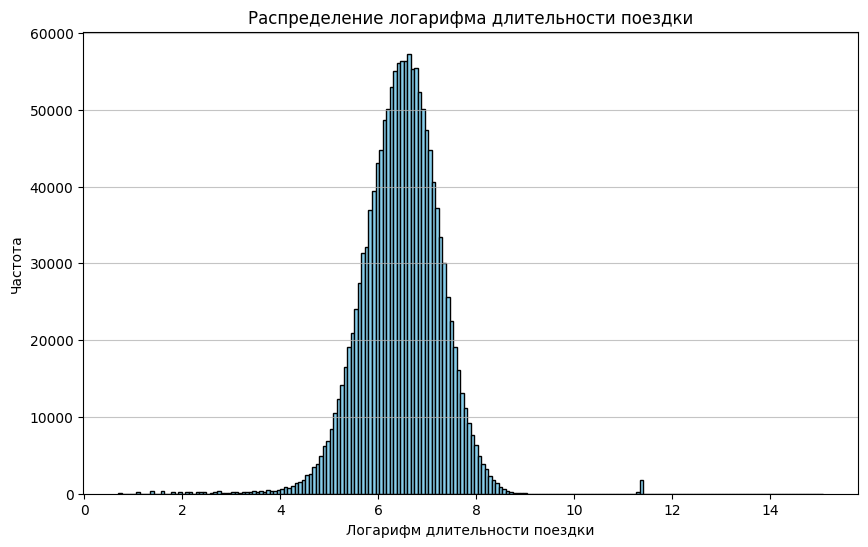

In [ ]:
db['log_trip_duration'] = np.log1p(db['trip_duration'])
# db = db.drop(columns=['trip_duration'])      Я не удалила, так как для вычисления
#                                              скорости эта колонка понадобится

plt.figure(figsize=(10, 6))
plt.hist(db['log_trip_duration'], bins=200, color='skyblue', edgecolor='black')
plt.title('Распределение логарифма длительности поездки')
plt.xlabel('Логарифм длительности поездки')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [ ]:
def rmsle(log1p_y_true, log1p_y_pred):
    return np.sqrt(np.mean((log1p_y_true - log1p_y_pred) ** 2))

log_trip_duration = db['log_trip_duration'].values

best_const_prediction = np.mean(log_trip_duration)

rmsle_best_const = rmsle(log_trip_duration, np.full_like(log_trip_duration, best_const_prediction))

assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году:

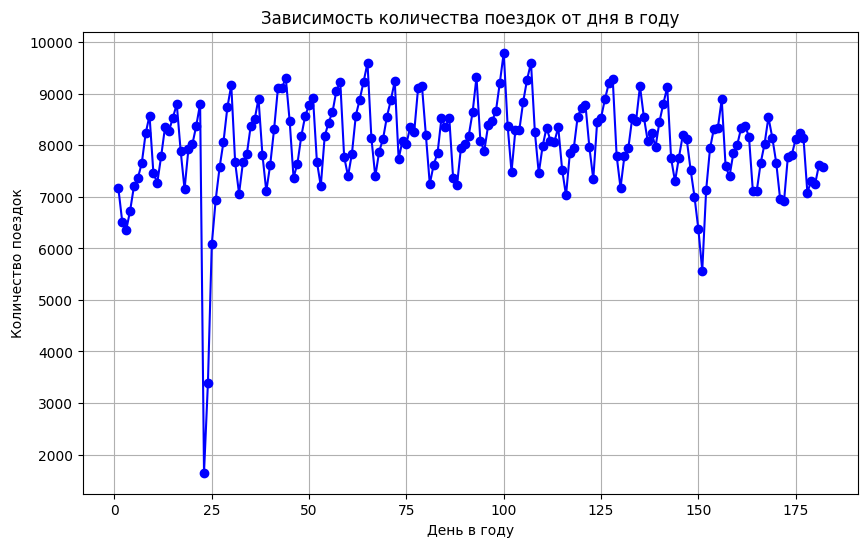

In [ ]:
db['day_of_year'] = db['pickup_datetime'].dt.dayofyear
trips_per_day = db.groupby('day_of_year').size()

plt.figure(figsize=(10, 6))
plt.plot(trips_per_day.index, trips_per_day.values, marker='o', linestyle='-', color='b')
plt.title('Зависимость количества поездок от дня в году')
plt.xlabel('День в году')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках:

In [ ]:
# Найдем минимальные дни по количеству поездок
import datetime
min_day_before_100 = trips_per_day[trips_per_day.index <= 100].idxmin()
min_trips_before_100 = trips_per_day.loc[min_day_before_100]

min_day_after_100 = trips_per_day[trips_per_day.index > 100].idxmin()
min_trips_after_100 = trips_per_day.loc[min_day_after_100]

# Выведем представление дня в году в понятном формате
min_day_before_100 = min_day_before_100.item()
min_day_after_100 = min_day_after_100.item()

min_day_before_100_date = datetime.datetime(2016, 1, 1) + datetime.timedelta(days=min_day_before_100 - 1)
min_day_after_100_date = datetime.datetime(2016, 1, 1) + datetime.timedelta(days=min_day_after_100 - 1)

print(f"Минимальный день в первый аномальный период: {min_day_before_100_date.strftime('%d %B')} ({min_day_before_100}) день")
print(f"Минимальный день во второй аномальный период: {min_day_after_100_date.strftime('%d %B')} ({min_day_after_100}) день")

Минимальный день в первый аномальный период: 23 January (23) день
Минимальный день во второй аномальный период: 30 May (151) день


Из информации в интернете можно выявить, что 23 января в Нью-Йорке была большая снежная буря:
https://www.rbc.ru/society/23/01/2016/56a3e5799a79474d3a9a9598

<img src="https://s0.rbk.ru/v6_top_pics/media/img/4/94/754535818859944.jpg" style="width: 400px">

Также спад поездок 30 мая можно объяснить также плохой погодой, а частности, дождями в этот период:
https://pogoda.mail.ru/prognoz/new_york/30-may/

По графику можно выделить 2 периода, опираясь на минимальные дни:
- 23 - 25 дни
- 150 - 151 дни

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, поищите, как это делается). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

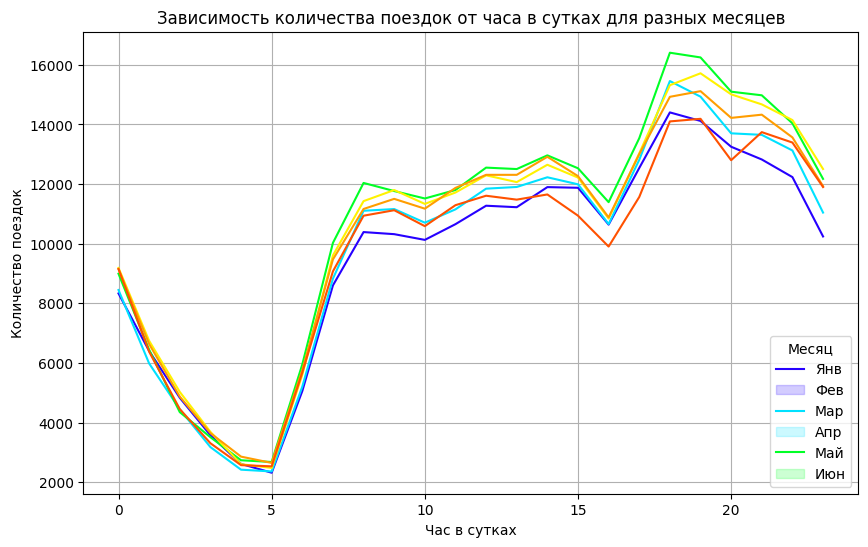

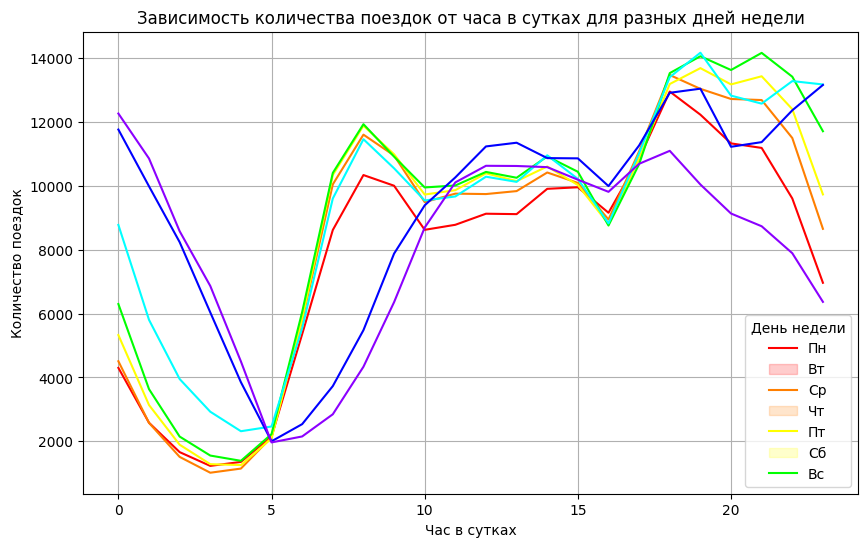

In [ ]:
db['hour'] = db['pickup_datetime'].dt.hour
db['month'] = db['pickup_datetime'].dt.month
db['day_of_week'] = db['pickup_datetime'].dt.dayofweek

trips_per_hour_month = db.groupby(['month', 'hour']).size().reset_index(name='trips')

colors = [
    '#2600FF',  # Январь
    '#00E1FF',  # Февраль
    '#00FF26',  # Март
    '#FFF200',  # Апрель
    '#FF9D00',  # Май
    '#FF5100',  # Июнь
]

plt.figure(figsize=(10, 6))
sns.lineplot(data=trips_per_hour_month, x='hour', y='trips', hue='month',
             palette=colors, hue_order=range(1, 7))

plt.title('Зависимость количества поездок от часа в сутках для разных месяцев')
plt.xlabel('Час в сутках')
plt.ylabel('Количество поездок')
plt.legend(title='Месяц', labels=['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн'],  loc='lower right')
plt.grid(True)
plt.show()

trips_per_hour_day = db.groupby(['day_of_week', 'hour']).size().reset_index(name='trips')

colors = [
    '#FF0000',  # Понедельник
    '#FF7F00',  # Вторник
    '#FFFF00',  # Среда
    '#00FF00',  # Четверг
    '#00FFFF',  # Пятница
    '#0000FF',  # Суббота
    '#8B00FF'   # Воскресенье
]

plt.figure(figsize=(10, 6))
sns.lineplot(data=trips_per_hour_day, x='hour', y='trips', hue='day_of_week',
             palette=colors, hue_order=[0, 1, 2, 3, 4, 5, 6])

plt.title('Зависимость количества поездок от часа в сутках для разных дней недели')
plt.xlabel('Час в сутках')
plt.ylabel('Количество поездок')
plt.legend(title='День недели', labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'], loc='lower right')
plt.grid(True)
plt.show()

По первому графику можно заметить следующие тенденции:
- в январе люди пользуются услугами такси значительно меньше в период 20:00 - 00:00, можно предположить, что в это холодное время люди сидят дома
- в июне в период 14:00 - 20:00 люди пользуются такси реже, чем обычно, я думаю, это связано с тем, что погода хорошая и люди предпочитают ходить пешком

По второму графику можно заметить следующие тенденции:
- в вс и сб заказов больше, чем обычно, в период 00:00 - 5:00, но меньше, чем обычно в период 5:00 - 11:00, так как это выходные дни, можно предположить, что ночью люди возвращаются после отдыха в общественных местах, а утром им не надо ехать на работу и они отдыхают дома
- в период 20:00 - 00:00 заказы в сб резко повышаются, в пт плавно повышаются, а в остальные дни резко идут на спад, это скорее всего связано с тем, что на следующий день им не надо на работу и люди выбирают выбраться куда-нибудь в это время
- в будние дни резкий скачок вверх в период 5:00 - 8:00 и в 16:00 - 19:00, это очевидно связано с приездом на работу и уездом с нее


**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

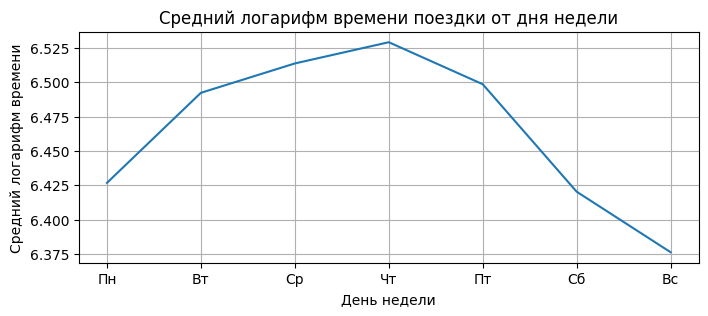

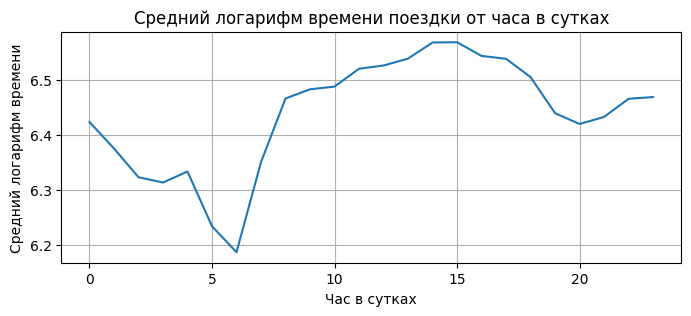

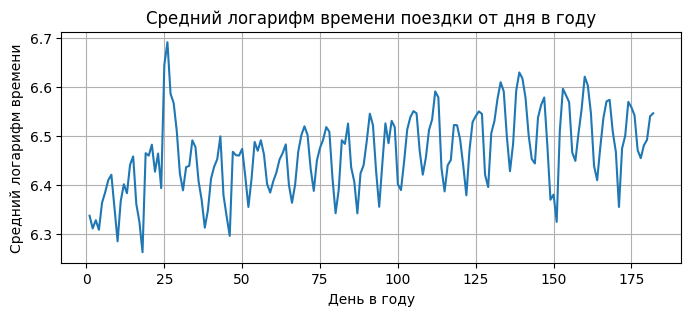

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(db, test_size=0.3, random_state=42)

plt.figure(figsize=(8, 3))
sns.lineplot(x='day_of_week', y='log_trip_duration', data=train, estimator='mean', errorbar=None)
plt.title('Средний логарифм времени поездки от дня недели')
plt.xlabel('День недели')
plt.ylabel('Средний логарифм времени')
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 3))
sns.lineplot(x='hour', y='log_trip_duration', data=train, estimator='mean', errorbar=None)
plt.title('Средний логарифм времени поездки от часа в сутках')
plt.xlabel('Час в сутках')
plt.ylabel('Средний логарифм времени')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 3))
sns.lineplot(x='day_of_year', y='log_trip_duration', data=train, estimator='mean', errorbar=None)
plt.title('Средний логарифм времени поездки от дня в году')
plt.xlabel('День в году')
plt.ylabel('Средний логарифм времени')
plt.grid(True)

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Графики похожи потому что есть нейкая прямая линейная зависимомость времени поездок от количества поездок (спроса на такси) в этот период. Средний таргет в первый аномальный период резко повышается после 25 дня в году.
Средний таргет во второй аномальный период резко снижается в этот период. Это может быть связано с погодными условиями (в первом случае спрос на долгие поездки, во втором наоборот).

Наблюдается увеличение таргета с увеличением дня в году.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [ ]:
# db['day_of_week'] = db['pickup_datetime'].dt.dayofweek
# db['month'] = db['pickup_datetime'].dt.month
# db['hour'] = db['pickup_datetime'].dt.hour
# db['day_of_year'] = db['pickup_datetime'].dt.dayofyear
anomalous_period_1_start, anomalous_period_1_end = 23, 25
anomalous_period_2_start, anomalous_period_2_end = 150, 151
db['is_anomalous_period_1'] = db['day_of_year'].between(anomalous_period_1_start, anomalous_period_1_end).astype(int)
db['is_anomalous_period_2'] = db['day_of_year'].between(anomalous_period_2_start, anomalous_period_2_end).astype(int)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

Так как
**Численные признаки** — это признаки, которые можно использовать для математических операций (например, суммы, среднего). Они представляют собой количественные значения.


**Категориальные признаки** — это признаки, которые группируют данные в различные категории, где числовая интерпретация не имеет смысла, как в случае с идентификаторами и флагами.

То я бы разделила следующим образом:

•	Категориальные: День недели, Месяц, Аномальные периоды, Час.

•	Численные: Номер дня в году.

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# db = db.dropna(subset=['log_trip_duration'])

categorical_features = ['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2']
numerical_features = ['day_of_year']

X = db[['day_of_year','day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2']]
y = db['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
train_mse = mean_squared_error(y_train, model.predict(X_train))
print(f'Train MSE: {train_mse}')
test_mse = mean_squared_error(y_test, y_pred)
print(f'Test RMSE : {test_mse}')

Train MSE: 0.6224606700972187
Test RMSE : 0.6209469973967418


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [ ]:
from typing import Iterable

def show_circles_on_map(
    latitude_values: Iterable[float],
    longitude_values: Iterable[float],
    color: str = "blue",
) -> folium.Map:
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    Works best on samples of size < 10k, too costly otherwise

    latitude_values: sample latitude values of a dataframe
    longitude_column: sample longitude values of a dataframe
    color: the color of circles to be drawn
    """

    location = (np.mean(latitude_values), np.mean(longitude_values))
    m = folium.Map(location=location)

    for lat, lon in zip(latitude_values, longitude_values):
        folium.Circle(
            radius=100,
            location=(lat, lon),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

Напишите функция, которая вернет значения колонок `pickup_latitude`, `pickup_longitude` на каком-нибудь разумном кусочке датафрейма, например, `df.sample(1000)` и покажите на карте, используя `show_circles_on_map`

In [ ]:
def get_sample_coordinates(df: pd.DataFrame, sample_size: int = 1000):
    """Returns sample of pickup_latitude and pickup_longitude from the DataFrame."""
    sample_df = db.sample(sample_size)
    return sample_df['pickup_latitude'], sample_df['pickup_longitude']

your_lat_values, your_lon_values = get_sample_coordinates(db, 300)
show_circles_on_map(your_lat_values, your_lon_values, color="midnightblue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?


На карте выделяются следующие скопления точек, которые могут быть полезны для анализа:

*   Пенсильванский вокзал (Penn Station) - главный междугородний железнодорожный вокзал Нью-Йорка и самый загруженный транспортный объект в Западном полушарии
*   Международный аэропорт имени Джона Кеннеди
*   Аэропорт Ла-Гвардия (LaGuardia Airport)
*   Район вокруг Здания Метлайф (MetLife Building)
*   Центральный парк и прилегающие к нему территории:
*   Митпэкинг (Meatpacking District) – модный торговый район в западной части Манхэттена
*   Бродвей-Лафайетт стрит (Broadway–Lafayette Street)


Эти скопления точек выделяются из-за их ключевого значения как транспортных узлов и центров активности, что делает их важными для анализа потоков такси и планирования логистики.

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [ ]:
# Код с семинара
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h
db.loc[:, 'haversine'] = haversine_array(db['pickup_latitude'].values, db['pickup_longitude'].values, db['dropoff_latitude'].values, db['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [ ]:
db['log_haversine'] = np.log1p(db['haversine'])

Посчитайте корреляцию и убедитесь, что логарифм расстояния лучше отражает таргет, чем просто расстояние:

In [ ]:
corr_haversine = db['log_trip_duration'].corr(db['haversine'])

corr_log_haversine = db['log_trip_duration'].corr(db['log_haversine'])

print(f"Корреляция с расстоянием: {corr_haversine}")
print(f"Корреляция с логарифмом расстояния: {corr_log_haversine}")

Корреляция с расстоянием: 0.5735948311180146
Корреляция с логарифмом расстояния: 0.7498822373942495


Как можем заметить корреляция между логарифмом расстояния и логарифмом времени больше, чем корреляция между обычным расстоянием и логарифмом времени; это связано с тем, что логарифмирование обеих переменных помогает сделать их зависимость более линейной и, следовательно, улучшает корреляцию.

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

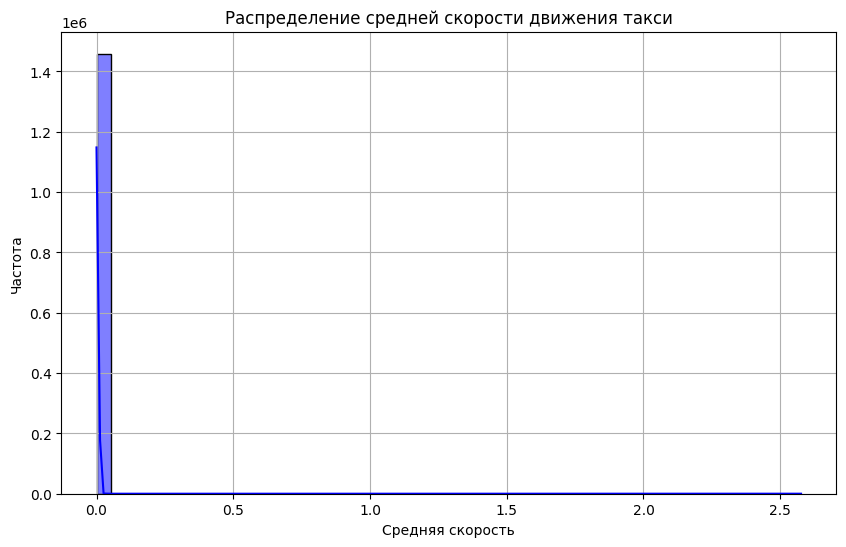

In [ ]:
db['average_speed'] = db['haversine'] / db['trip_duration']

plt.figure(figsize=(10, 6))
sns.histplot(db['average_speed'], bins=50, kde=True, color='blue')

plt.title('Распределение средней скорости движения такси')
plt.xlabel('Средняя скорость')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

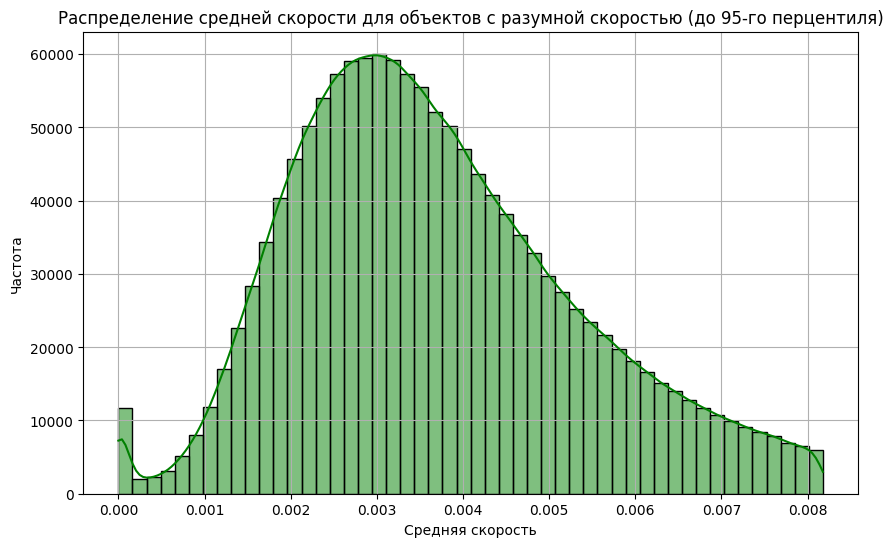

In [ ]:
reasonable_speed_data = db[db['average_speed'] <= db['average_speed'].quantile(0.95)]

plt.figure(figsize=(10, 6))
sns.histplot(reasonable_speed_data['average_speed'], bins=50, kde=True, color='green')
plt.title('Распределение средней скорости для объектов с разумной скоростью (до 95-го перцентиля)')
plt.xlabel('Средняя скорость')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте Heatmap-график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

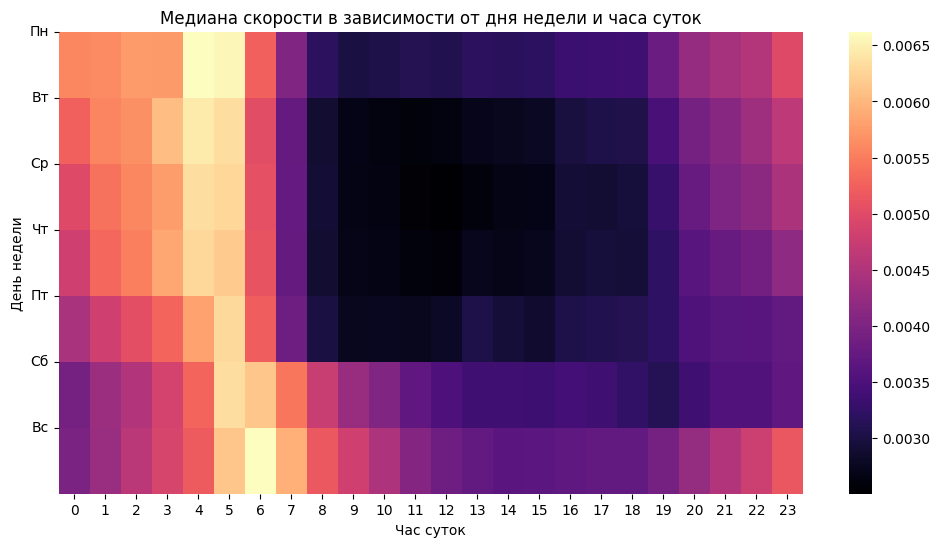

In [ ]:
median_speed = db.groupby(['day_of_week', 'hour'])['average_speed'].median().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(median_speed, cmap="magma")

plt.title('Медиана скорости в зависимости от дня недели и часа суток')
plt.xlabel('Час суток')
plt.ylabel('День недели')
plt.yticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'], rotation=0)

plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [ ]:
db = db.drop(columns=['average_speed'])

Использование колонки с информацией о скорости может привести к утечке информации, так как это значение непосредственно связано с длительностью поездки. Модель может «узнать» о скорости и, таким образом, предсказать длительность поездки на основе уже известной информации, что не соответствует реальным условиям.

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [ ]:
def classify_traffic_periods(row):
    day_of_week = row['day_of_week']
    hour = row['hour']

    if day_of_week in [0, 1, 2, 3, 4] and 8 <= hour < 18:  # Пн - Пт, 8:00 - 18:00
        return 1
    else:
        return 0

def classify_free_traffic_periods(row):
    day_of_week = row['day_of_week']
    hour = row['hour']

    if (day_of_week in [0, 1, 2, 3, 4] and 4 <= hour < 6) or (day_of_week in [5, 6] and 5 <= hour < 7):  # Пн - Пт, 4:00 - 6:00 и Сб - Вс, 5:00 - 7:00
        return 1
    else:
        return 0

db['jam_flag'] = db.apply(classify_traffic_periods, axis=1)
db['free_flag'] = db.apply(classify_free_traffic_periods, axis=1)

Скорость минимальна в период: вторник - пятница 9:00 - 16:00 (если немного расширить дипазон, то 8:00 - 18:00).

Скорость максимальна в периоды: будние 4:00 - 6:00, выходные 5:00 - 7:00.

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

In [ ]:
locations = {
    'Penn_Station': (40.7506, -73.9935),  # Координаты Penn Station
    'JFK_Airport': (40.6413, -73.7781),   # Координаты аэропорта JFK
    # 'LaGuardia_Airport': (40.7769, -73.8740)  # Координаты аэропорта Ла-Гвардия
}

threshold = 0.5
def is_starting_at_location(row, location_coords):
    return haversine_array(row['pickup_latitude'], row['pickup_longitude'], *location_coords) <= threshold

def is_ending_at_location(row, location_coords):
    return haversine_array(row['dropoff_latitude'], row['dropoff_longitude'], *location_coords) <= threshold

for location_name, coords in locations.items():
    db[f'starts_at_{location_name}'] = db.apply(is_starting_at_location, location_coords=coords, axis=1)
    db[f'ends_at_{location_name}'] = db.apply(is_ending_at_location, location_coords=coords, axis=1)

Для каждого из созданных признаков нарисуйте "ящик с усами" (aka boxplot) распределения логарифма времени поездки

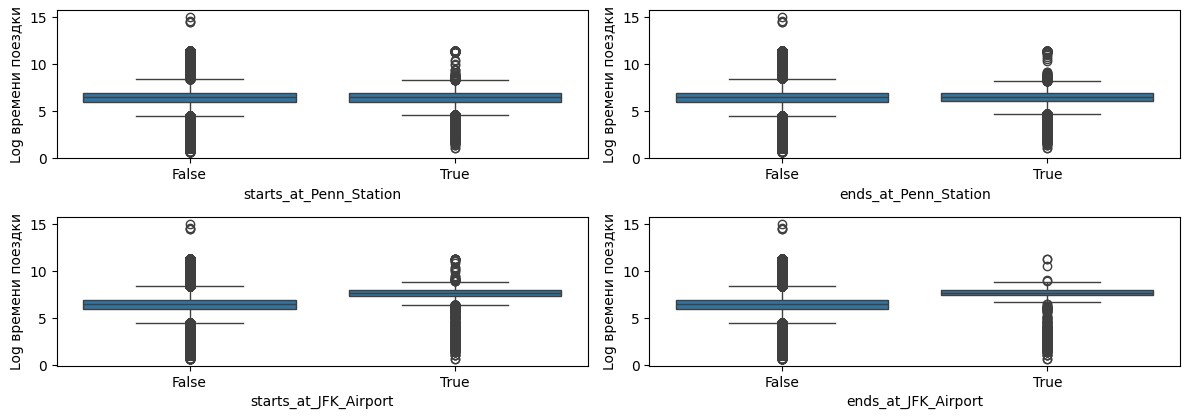

In [ ]:
features = [
    'starts_at_Penn_Station', 'ends_at_Penn_Station',
    'starts_at_JFK_Airport', 'ends_at_JFK_Airport'
    # 'starts_at_LaGuardia_Airport', 'ends_at_LaGuardia_Airport'
]

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(4, 2, i + 1)
    sns.boxplot(data=db, x=feature, y='log_trip_duration')
    plt.xlabel(feature)
    plt.ylabel('Log времени поездки')

plt.tight_layout()
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

Признаки по JFK_Airport получились лучше, чем по Penn_Station, так как во втором случае получились примерно одинаковые распределения в зависимости от значений признаков. Но как будто бы оба признака не особо влиятелельные.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [ ]:
import folium
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rows=10, columns=10, width=0.07, height=0.1):
        self.rows = rows
        self.columns = columns
        self.width = width
        self.height = height
        self.center = (40.772093, -74.003788)
        self.cell_width = width / columns
        self.cell_height = height / rows

    def show_map(self):
        folium_map = folium.Map(location=self.center, zoom_start=13)

        lon_min = self.center[1] - self.width / 2
        lat_min = self.center[0] - self.height / 2

        for i in range(self.rows):
            for j in range(self.columns):
                lat_start = lat_min + i * self.cell_height
                lon_start = lon_min + j * self.cell_width
                lat_end = lat_start + self.cell_height
                lon_end = lon_start + self.cell_width

                folium.Rectangle(
                    bounds=[(lat_start, lon_start), (lat_end, lon_end)],
                    color="blue",
                    fill=True,
                    fill_opacity=0.1
                ).add_to(folium_map)

        return folium_map

    def fit(self, X = None, y = None):
        self.center = (X['pickup_latitude'].mean(), X['pickup_longitude'].mean())
        self.offset_lat = self.center[0] - self.height * 0.5
        self.offset_lon = self.center[1] - self.width * 0.5
        return self

    def transform(self, X, y = None):
        out = X.copy()

        pickup_lat_idx = ((out['pickup_latitude'] - self.offset_lat) / self.cell_height).astype(int)
        pickup_lon_idx = ((out['pickup_longitude'] - self.offset_lon) / self.cell_width).astype(int)
        dropoff_lat_idx = ((out['dropoff_latitude'] - self.offset_lat) / self.cell_height).astype(int)
        dropoff_lon_idx = ((out['dropoff_longitude'] - self.offset_lon) / self.cell_width).astype(int)

        out['pickup_zone'] = np.where(
            (pickup_lat_idx >= 0) & (pickup_lat_idx < self.rows) &
            (pickup_lon_idx >= 0) & (pickup_lon_idx < self.columns),
            pickup_lat_idx * self.columns + pickup_lon_idx,
            -1
        )

        out['dropoff_zone'] = np.where(
            (dropoff_lat_idx >= 0) & (dropoff_lat_idx < self.rows) &
            (dropoff_lon_idx >= 0) & (dropoff_lon_idx < self.columns),
            dropoff_lat_idx * self.columns + dropoff_lon_idx,
            -1
        )

        return out

In [ ]:
train, test = train_test_split(db, test_size=0.3, random_state=42)

X_train = train.drop(columns=['trip_duration', 'log_trip_duration'])
y_train = train[['log_trip_duration']]
X_test = test.drop(columns=['trip_duration', 'log_trip_duration'])
y_test = test[['log_trip_duration']]

transformer = MapGridTransformer()
transformer.fit(X_train)

db = transformer.transform(db)

X_train_transformed = transformer.transform(X_train)
X_test_transformed = transformer.transform(X_test)

db = transformer.transform(db)

folium_map = transformer.show_map()
folium_map.save("grid_map.html")

Получилось такое разбиение:

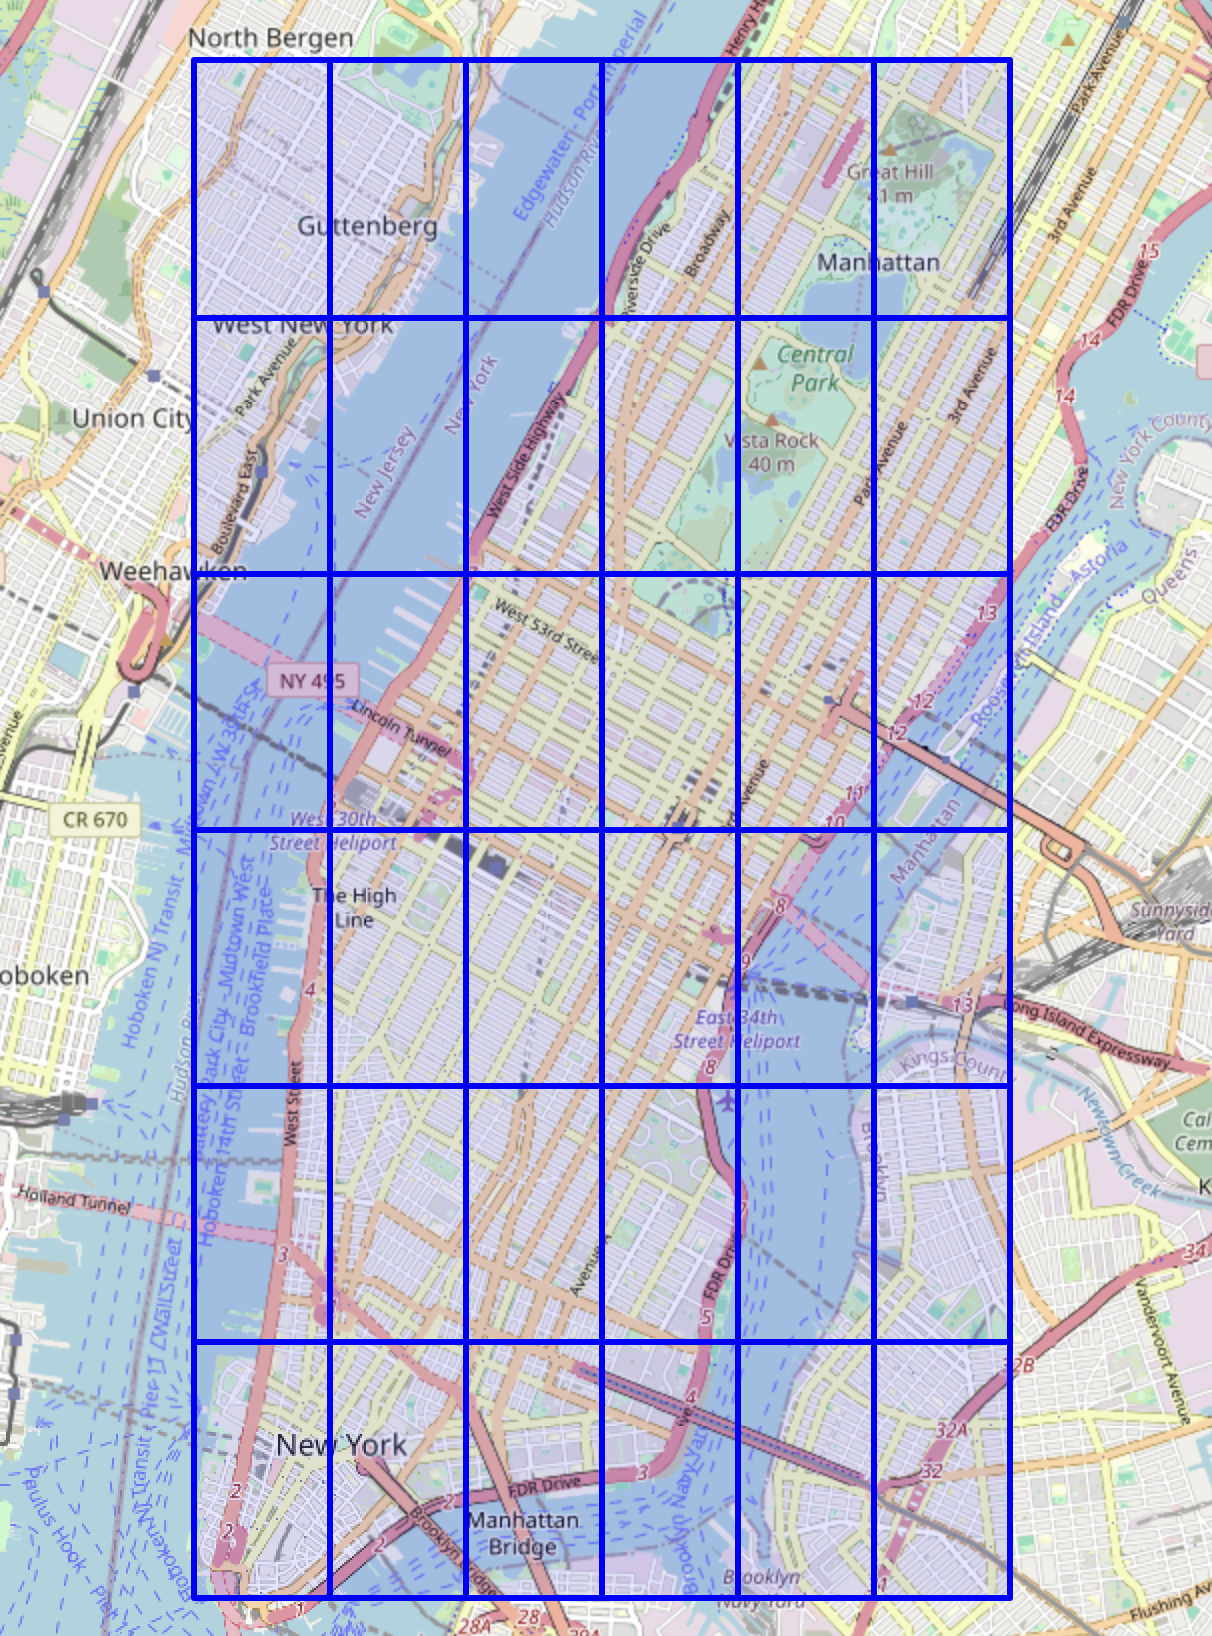

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [ ]:
categorical_features = ['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2', 'pickup_zone', 'dropoff_zone', 'log_haversine',
                        'jam_flag', 'free_flag', 'starts_at_Penn_Station', 'ends_at_Penn_Station', 'starts_at_JFK_Airport', 'ends_at_JFK_Airport']
numerical_features = ['day_of_year', 'log_haversine']

X = db[['day_of_week', 'month', 'hour', 'day_of_year', 'pickup_zone', 'dropoff_zone', 'log_haversine',
        'is_anomalous_period_1', 'is_anomalous_period_2', 'jam_flag', 'free_flag',
        'starts_at_Penn_Station', 'ends_at_Penn_Station', 'starts_at_JFK_Airport', 'ends_at_JFK_Airport']]
y = db['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
train_mse = mean_squared_error(y_train, model.predict(X_train))
print(f'Train MSE: {train_mse}')
test_mse = mean_squared_error(y_test, y_pred)
print(f'Test RMSE : {test_mse}')

Train MSE: 0.06608017885245114
Test RMSE : 0.22284173047280895


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [ ]:
unique_vendor_id = db['vendor_id'].nunique()
print("Количество уникальных значений в vendor_id:", unique_vendor_id)
unique_passenger_count = db['passenger_count'].nunique()
print("Количество уникальных значений в passenger_count:", unique_passenger_count)
unique_store_and_fwd_flag = db['store_and_fwd_flag'].nunique()
print("Количество уникальных значений в store_and_fwd_flag:", unique_store_and_fwd_flag)

Количество уникальных значений в vendor_id: 2
Количество уникальных значений в passenger_count: 10
Количество уникальных значений в store_and_fwd_flag: 2


Каждый из этих признаков может быть потенциально полезен, так как:


*   vendor_id: может влиять на продолжительность поездки, так как у разных поставщиков могут быть различия в маршрутах, стратегии приема заказов, или типах автомобилей, что может повлиять на время в пути.
*   passenger_count: может оказывать влияние на время поездки: для больших групп могут быть выбраны более вместительные автомобили, которые могут двигаться медленнее, или поездка может быть длиннее, если требуется собрать всех пассажиров с разных точек.
*   store_and_fwd_flag: показывает, была ли информация о поездке сохранена и передана позже. Если флаг установлен, это может указывать на районы с плохой сетью, где поездки могут занять больше времени из-за потерь связи, которые могут повлиять на маршруты и время в пути.





Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

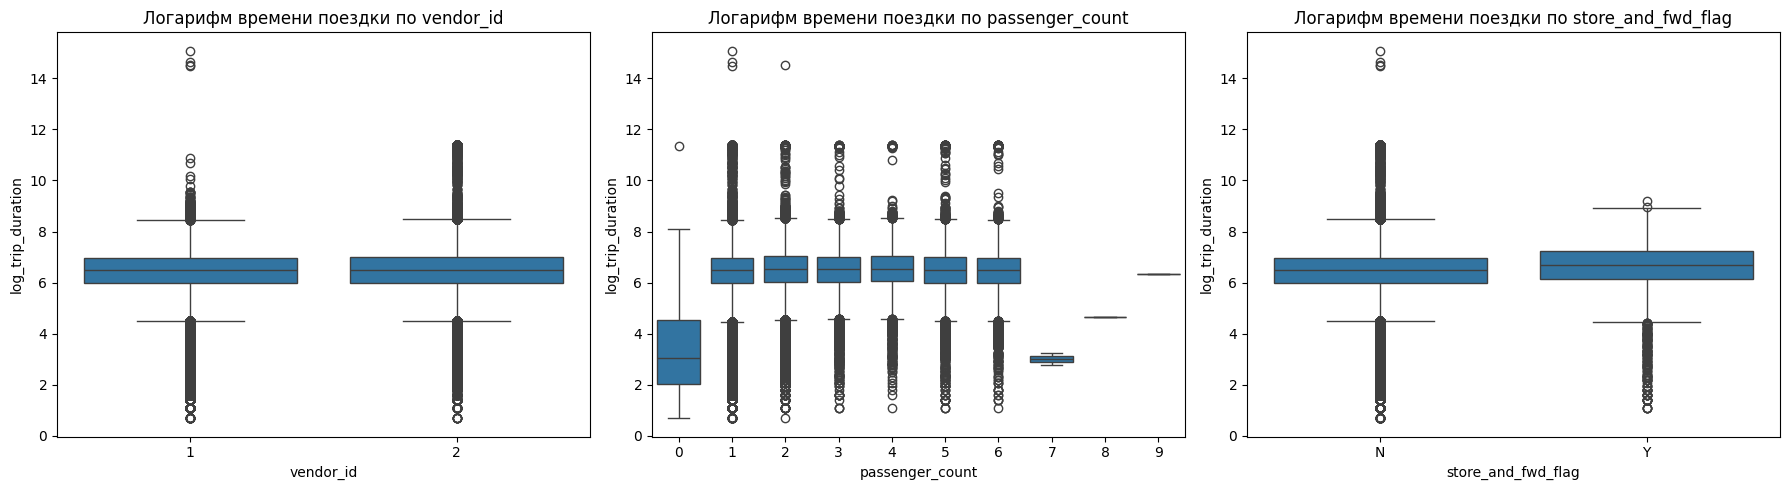

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='vendor_id', y='log_trip_duration', data=db)
plt.title('Логарифм времени поездки по vendor_id')

plt.subplot(1, 3, 2)
sns.boxplot(x='passenger_count', y='log_trip_duration', data=db)
plt.title('Логарифм времени поездки по passenger_count')

plt.subplot(1, 3, 3)
sns.boxplot(x='store_and_fwd_flag', y='log_trip_duration', data=db)
plt.title('Логарифм времени поездки по store_and_fwd_flag')

plt.tight_layout()
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [ ]:
db['vendor_id'] = db['vendor_id'].apply(lambda x: 0 if x == 1 else 1) # 2 comp — 1, а 1 comp - 0

db['store_and_fwd_flag'] = db['store_and_fwd_flag'].apply(lambda x: 1 if x == 'Y' else 0) # 'Y' - 1, а 'N' — 0

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Так как в признаках vendor_id и store_and_fwd_flag различия в основном отличаются только в выбросах, а медиана и края статистически значимой выборки примерно одинкаковые у различных значений признков, то можно предположить, что они не будут значимыми.

У признака passenger_count можно наблюдать различные распределения распределения логарифма времени поездки в зависимости от значения, поэтому он будет более значимый, хотя у большинства значений (1 - 6) распределение все-таки очень похожее.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [ ]:
categorical_features = ['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2', 'pickup_zone', 'dropoff_zone',
                        'jam_flag', 'free_flag', 'starts_at_Penn_Station', 'ends_at_Penn_Station', 'starts_at_JFK_Airport', 'ends_at_JFK_Airport',
                        'vendor_id', 'passenger_count', 'store_and_fwd_flag']
numerical_features = ['day_of_year', 'log_haversine']

X = db[['day_of_week', 'month', 'hour', 'day_of_year', 'pickup_zone', 'dropoff_zone', 'log_haversine',
        'is_anomalous_period_1', 'is_anomalous_period_2', 'jam_flag', 'free_flag',
        'starts_at_Penn_Station', 'ends_at_Penn_Station', 'starts_at_JFK_Airport', 'ends_at_JFK_Airport',
        'vendor_id', 'passenger_count', 'store_and_fwd_flag']]
y = db['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
train_mse = mean_squared_error(y_train, model.predict(X_train))
print(f'Train MSE: {train_mse}')
test_mse = mean_squared_error(y_test, y_pred)
print(f'Test RMSE : {test_mse}')

Train MSE: 0.22415421832339244
Test RMSE : 0.2238719108686517


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [ ]:
db = db.drop(columns=['store_and_fwd_flag', 'vendor_id', 'passenger_count'])

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

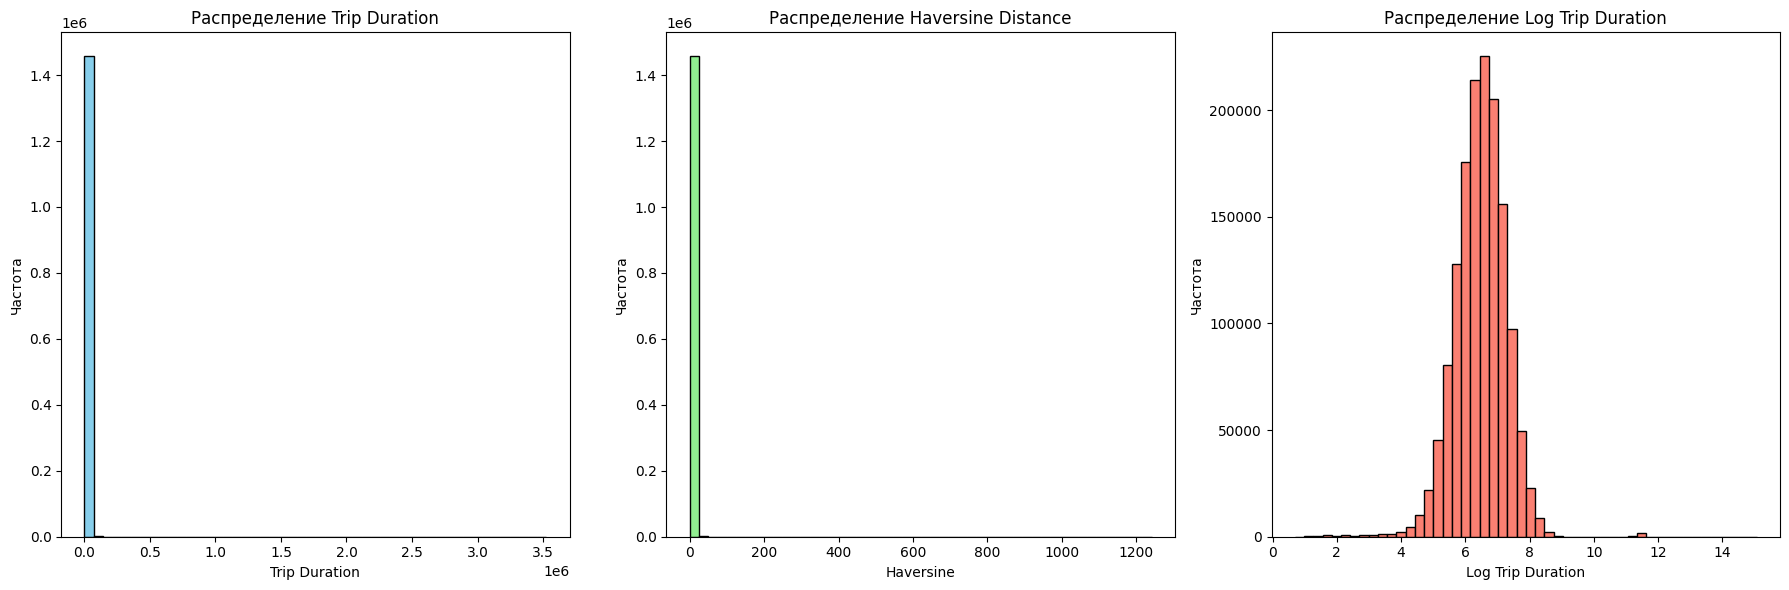

In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(db['trip_duration'], bins=50, color='skyblue', edgecolor='black')
plt.title('Распределение Trip Duration')
plt.xlabel('Trip Duration')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
plt.hist(db['haversine'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Распределение Haversine Distance')
plt.xlabel('Haversine')
plt.ylabel('Частота')

plt.subplot(1, 3, 3)
plt.hist(db['log_trip_duration'], bins=50, color='salmon', edgecolor='black')
plt.title('Распределение Log Trip Duration')
plt.xlabel('Log Trip Duration')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [ ]:
threshold = 100

def combine_rare_categories(df, column, threshold):
    counts = df[column].value_counts()
    rare_categories = counts[counts < threshold].index
    df[column] = df[column].replace(rare_categories, -2)
    return df

categorical_columns = ['pickup_zone', 'dropoff_zone']

for col in categorical_columns:
    db = combine_rare_categories(db, col, threshold)

Так как у нас признаки в основном бинарные: 'is_anomalous_period_1', 'is_anomalous_period_2', 'jam_flag', 'free_flag', 'starts_at_Penn_Station', 'ends_at_Penn_Station', 'starts_at_JFK_Airport', 'ends_at_JFK_Airport','vendor_id' - они не требуют объединения редких категорий, так как бинарные признаки имеют только два значения.

Для остальных категориальных признаков, таких как day_of_week, month, и hour, также не требуется объединение редких категорий, так как их значения относятся к естественным временным категориям, которые встречаются в данных регулярно.

Таким образом, дополнительной обработки категорий для исключения редких значений в данном случае требуется только для 'pickup_zone', 'dropoff_zone'.

In [ ]:
train, test = train_test_split(db, test_size=0.3, random_state=42)

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.05)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

train = remove_outliers_iqr(train, 'trip_duration')
train = remove_outliers_iqr(train, 'haversine')
train = remove_outliers_iqr(train, 'log_trip_duration')

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.


In [ ]:
X_train = train[['day_of_week', 'month', 'hour', 'day_of_year', 'log_haversine', 'pickup_zone', 'dropoff_zone',
        'is_anomalous_period_1', 'is_anomalous_period_2', 'jam_flag', 'free_flag',
        'starts_at_Penn_Station', 'ends_at_Penn_Station', 'starts_at_JFK_Airport', 'ends_at_JFK_Airport']]

y_train = train['log_trip_duration']

X_test = test[['day_of_week', 'month', 'hour', 'day_of_year', 'log_haversine', 'pickup_zone', 'dropoff_zone',
        'is_anomalous_period_1', 'is_anomalous_period_2', 'jam_flag', 'free_flag',
        'starts_at_Penn_Station', 'ends_at_Penn_Station', 'starts_at_JFK_Airport', 'ends_at_JFK_Airport']]

y_test = test['log_trip_duration']

categorical_features = ['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2',
                        'jam_flag', 'free_flag', 'starts_at_Penn_Station', 'ends_at_Penn_Station', 'starts_at_JFK_Airport', 'ends_at_JFK_Airport',
                        'pickup_zone', 'dropoff_zone']
numerical_features = ['day_of_year', 'log_haversine']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
train_mse = mean_squared_error(y_train, model.predict(X_train))
print(f'Train MSE: {train_mse}')
test_mse = mean_squared_error(y_test, y_pred)
print(f'Test RMSE : {test_mse}')

Train MSE: 0.1857639747110408
Test RMSE : 0.2243438482741982


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
ohe = OneHotEncoder(handle_unknown="ignore")
testing = ohe.fit_transform(X_train[categorical_features])
print(X_train.shape[1], testing.shape[1])

15 224


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [ ]:
from sklearn.linear_model import Lasso

X_train = train[['day_of_week', 'month', 'hour', 'day_of_year', 'log_haversine', 'pickup_zone', 'dropoff_zone',
        'is_anomalous_period_1', 'is_anomalous_period_2', 'jam_flag', 'free_flag',
        'starts_at_Penn_Station', 'ends_at_Penn_Station', 'starts_at_JFK_Airport', 'ends_at_JFK_Airport']]

y_train = train['log_trip_duration']

X_test = test[['day_of_week', 'month', 'hour', 'day_of_year', 'log_haversine', 'pickup_zone', 'dropoff_zone',
        'is_anomalous_period_1', 'is_anomalous_period_2', 'jam_flag', 'free_flag',
        'starts_at_Penn_Station', 'ends_at_Penn_Station', 'starts_at_JFK_Airport', 'ends_at_JFK_Airport']]

y_test = test['log_trip_duration']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
train_mse = mean_squared_error(y_train, model.predict(X_train))
print(f'Train MSE: {train_mse}')
test_mse = mean_squared_error(y_test, y_pred)
print(f'Test RMSE : {test_mse}')

Train MSE: 0.5853502017591633
Test RMSE : 0.6321363785341485


Ridge-регрессия лучше.

Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

Best alpha (Ridge) = 0.1292
Best alpha (Lasso) = 0.0010
Zero weights in Lasso: 1


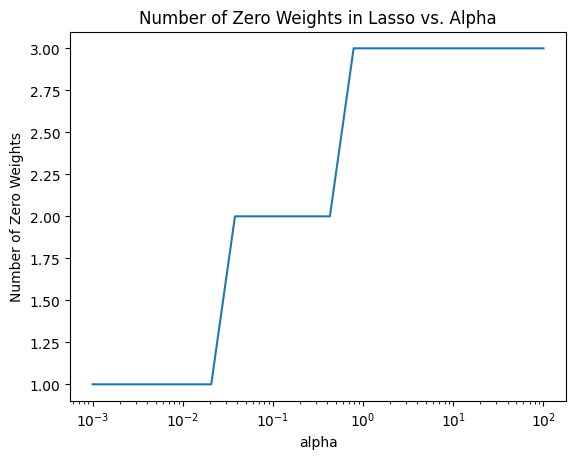

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, root_mean_squared_error

train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(train_data[numerical_features])
x_val_scaled = scaler.transform(val_data[numerical_features])
y_train = train_data['log_trip_duration']
y_val = val_data['log_trip_duration']
x_test_scaled = scaler.transform(test[numerical_features])
y_test = test['log_trip_duration']

alphas = np.logspace(-2, 3, 10)
ridge_searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
ridge_searcher.fit(x_train_scaled, y_train)

best_alpha_ridge = ridge_searcher.best_params_["alpha"]
print("Best alpha (Ridge) = %.4f" % best_alpha_ridge)


alphas = np.logspace(-3, 2, 20)
lasso_searcher = GridSearchCV(Lasso(max_iter=10000), [{"alpha": alphas}],
                              scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
lasso_searcher.fit(x_train_scaled, y_train)

best_alpha_lasso = lasso_searcher.best_params_["alpha"]
print("Best alpha (Lasso) = %.4f" % best_alpha_lasso)


lasso_model = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_model.fit(x_train_scaled, y_train)
lasso_zeros = np.sum(lasso_model.coef_ == 0)
print("Zero weights in Lasso:", lasso_zeros)

zero_weights_count = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(x_train_scaled, y_train)
    zero_weights_count.append(np.sum(lasso.coef_ == 0))

plt.plot(alphas, zero_weights_count)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("Number of Zero Weights")
plt.title("Number of Zero Weights in Lasso vs. Alpha")
plt.show()

Сохраните наилучшее значение, как бенчмарк на будущее


In [ ]:
best_model = Ridge(alpha=best_alpha_ridge) if ridge_searcher.best_score_ > lasso_searcher.best_score_ else Lasso(alpha=best_alpha_lasso, max_iter=10000)
best_model.fit(x_train_scaled, y_train)
y_test_pred = best_model.predict(x_test_scaled)
test_rmse = root_mean_squared_error(y_test, y_test_pred)
print(f"Best alpha: {best_model}")
print(f"Test RMSE of the best model: {test_rmse}")

Best alpha: Ridge(alpha=0.1291549665014884)
Test RMSE of the best model: 0.5255147379684044


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

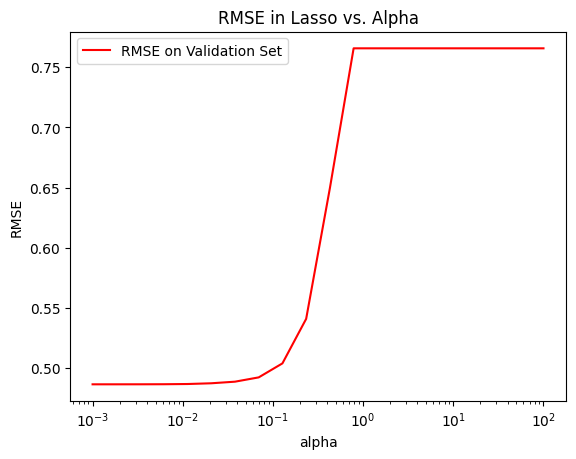

Alpha for approximately half-zero weights: 0.0379269019073225
RMSE for Lasso model with half-zero weights: 0.4887954494649471
Quality loss when eliminating approximately half of the features: 0.0021956257744604746


In [ ]:
zero_weights_count = []
rmse_scores = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(x_train_scaled, y_train)
    zero_weights = np.sum(lasso.coef_ == 0)
    zero_weights_count.append(zero_weights)

    y_val_pred = lasso.predict(x_val_scaled)
    rmse = root_mean_squared_error(y_val, y_val_pred)
    rmse_scores.append(rmse)

plt.plot(alphas, rmse_scores, label="RMSE on Validation Set", color="red")
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.title("RMSE in Lasso vs. Alpha")
plt.legend()
plt.show()

total_features = x_train_scaled.shape[1]
target_zero_weights = total_features // 2
closest_alpha_idx = np.argmin(np.abs(np.array(zero_weights_count) - target_zero_weights))
alpha_for_half_zero_weights = alphas[closest_alpha_idx]
rmse_for_half_zero_weights = rmse_scores[closest_alpha_idx]

print(f"Alpha for approximately half-zero weights: {alpha_for_half_zero_weights}")
print(f"RMSE for Lasso model with half-zero weights: {rmse_for_half_zero_weights}")

best_rmse = min(rmse_scores)
quality_loss = rmse_for_half_zero_weights - best_rmse
print(f"Quality loss when eliminating approximately half of the features: {quality_loss}")

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
zone_pairs = db.groupby(['pickup_zone', 'dropoff_zone']).size().reset_index(name='count')
top_100_pairs = zone_pairs.nlargest(100, 'count')[['pickup_zone', 'dropoff_zone']]

top_100_pairs['pair_index'] = range(1, 101)
top_100_dict = {(row['pickup_zone'], row['dropoff_zone']): row['pair_index'] for _, row in top_100_pairs.iterrows()}

def encode_trip(row):
    return top_100_dict.get((row['pickup_zone'], row['dropoff_zone']), -1)

db['top_trip_pair'] = db.apply(encode_trip, axis=1)

Линейная модель рассматривает каждый признак отдельно и не может автоматически создавать комбинации признаков, такие как пары зон. Даже если у нас есть два признака — “ячейка начала” и “ячейка конца”, — линейная модель не способна напрямую учитывать их взаимодействие без дополнительного кодирования. Линейные модели предполагают независимость признаков, а в данном случае важен именно совместный эффект пар зон.

Такой признак потенциально полезен, потому что он учитывает частоту и важность конкретных маршрутов. Взаимодействия, подобные этим, могут показать, что поездки между определёнными зонами (ячейками) имеют уникальные особенности, такие как типичное время поездки или уровень загруженности. Часто именно такие пары могут характеризовать ключевые маршруты, например, между популярными туристическими местами или транспортными узлами, где поездки имеют предсказуемую продолжительность, независимо от расстояния или других факторов.

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
train, test = train_test_split(db, test_size=0.3, random_state=42)

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.05)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

train = remove_outliers_iqr(train, 'trip_duration')
train = remove_outliers_iqr(train, 'haversine')
train = remove_outliers_iqr(train, 'log_trip_duration')

In [ ]:
X_train = train[['day_of_week', 'month', 'hour', 'day_of_year', 'log_haversine', 'pickup_zone', 'dropoff_zone',
        'is_anomalous_period_1', 'is_anomalous_period_2', 'jam_flag', 'free_flag',
        'starts_at_Penn_Station', 'ends_at_Penn_Station', 'starts_at_JFK_Airport', 'ends_at_JFK_Airport',
                 'top_trip_pair']]

y_train = train['log_trip_duration']

X_test = test[['day_of_week', 'month', 'hour', 'day_of_year', 'log_haversine', 'pickup_zone', 'dropoff_zone',
        'is_anomalous_period_1', 'is_anomalous_period_2', 'jam_flag', 'free_flag',
        'starts_at_Penn_Station', 'ends_at_Penn_Station', 'starts_at_JFK_Airport', 'ends_at_JFK_Airport',
               'top_trip_pair']]

y_test = test['log_trip_duration']

categorical_features = ['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2',
                        'jam_flag', 'free_flag', 'starts_at_Penn_Station', 'ends_at_Penn_Station', 'starts_at_JFK_Airport', 'ends_at_JFK_Airport',
                        'pickup_zone', 'dropoff_zone', 'top_trip_pair']
numerical_features = ['day_of_year', 'log_haversine']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
train_mse = mean_squared_error(y_train, model.predict(X_train))
print(f'Train MSE: {train_mse}')
test_mse = mean_squared_error(y_test, y_pred)
print(f'Test RMSE : {test_mse}')

Train MSE: 0.18129299555644054
Test RMSE : 0.21995393897482154


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [ ]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

db['distance_dummy_manhattan'] = dummy_manhattan_distance(
    db['pickup_latitude'].values,
    db['pickup_longitude'].values,
    db['dropoff_latitude'].values,
    db['dropoff_longitude'].values
)

db['log_distance_dummy_manhattan'] = np.log1p(db['distance_dummy_manhattan'])


corr_haversine = db['log_haversine'].corr(db['log_trip_duration'])
corr_manhattan = db['log_distance_dummy_manhattan'].corr(db['log_trip_duration'])

print(f"Корреляция distance_haversine с log_trip_duration: {corr_haversine}")
print(f"Корреляция log_distance_dummy_manhattan с log_trip_duration: {corr_manhattan}")

Корреляция distance_haversine с log_trip_duration: 0.7498822373942495
Корреляция log_distance_dummy_manhattan с log_trip_duration: 0.744761798767847


In [ ]:
import math
theta = math.radians(34)

def rotate_coords(lat, lng, center_lat=40.758896, center_lng=-73.985130, theta=theta):
    lat_rel = lat - center_lat
    lng_rel = lng - center_lng

    lat_rot = lat_rel * math.cos(theta) - lng_rel * math.sin(theta)
    lng_rot = lat_rel * math.sin(theta) + lng_rel * math.cos(theta)

    return lat_rot + center_lat, lng_rot + center_lng

m = folium.Map(location=[40.758896, -73.985130], zoom_start=12)

for lat in np.linspace(40.70, 40.85, 10):
    start_lat, start_lng = rotate_coords(lat, -74.02)
    end_lat, end_lng = rotate_coords(lat, -73.92)
    folium.PolyLine([(start_lat, start_lng), (end_lat, end_lng)], color="blue", weight=1).add_to(m)

for lng in np.linspace(-74.02, -73.92, 10):
    start_lat, start_lng = rotate_coords(40.70, lng)
    end_lat, end_lng = rotate_coords(40.85, lng)
    folium.PolyLine([(start_lat, start_lng), (end_lat, end_lng)], color="blue", weight=1).add_to(m)

m

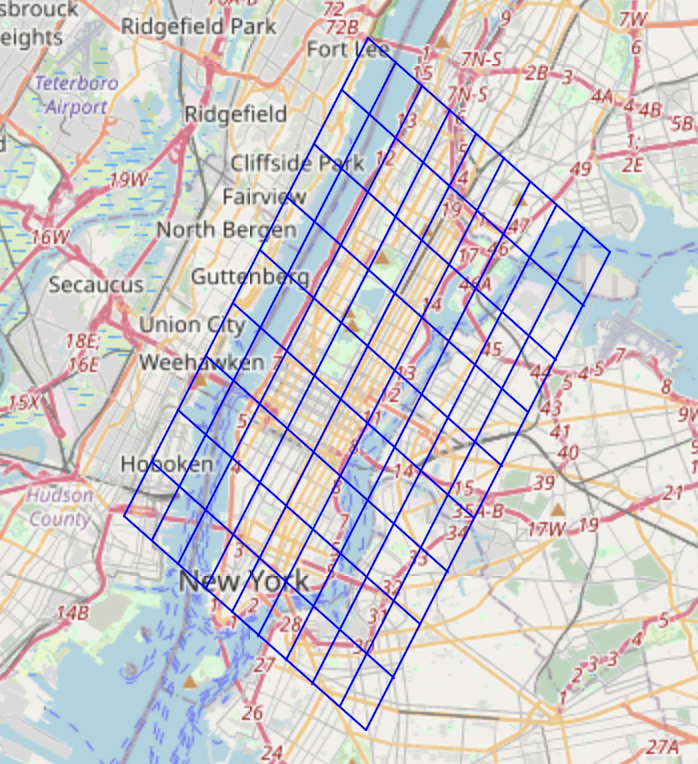

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
train, test = train_test_split(db, test_size=0.3, random_state=42)

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.05)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

train = remove_outliers_iqr(train, 'trip_duration')
train = remove_outliers_iqr(train, 'haversine')
train = remove_outliers_iqr(train, 'log_trip_duration')

In [ ]:
X_train = train[['day_of_week', 'month', 'hour', 'day_of_year', 'log_haversine', 'pickup_zone', 'dropoff_zone',
        'is_anomalous_period_1', 'is_anomalous_period_2', 'jam_flag', 'free_flag',
        'starts_at_Penn_Station', 'ends_at_Penn_Station', 'starts_at_JFK_Airport', 'ends_at_JFK_Airport',
                 'top_trip_pair', 'log_distance_dummy_manhattan']]

y_train = train['log_trip_duration']

X_test = test[['day_of_week', 'month', 'hour', 'day_of_year', 'log_haversine', 'pickup_zone', 'dropoff_zone',
        'is_anomalous_period_1', 'is_anomalous_period_2', 'jam_flag', 'free_flag',
        'starts_at_Penn_Station', 'ends_at_Penn_Station', 'starts_at_JFK_Airport', 'ends_at_JFK_Airport',
               'top_trip_pair', 'log_distance_dummy_manhattan']]

y_test = test['log_trip_duration']

categorical_features = ['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2',
                        'jam_flag', 'free_flag', 'starts_at_Penn_Station', 'ends_at_Penn_Station', 'starts_at_JFK_Airport', 'ends_at_JFK_Airport',
                        'pickup_zone', 'dropoff_zone', 'top_trip_pair']
numerical_features = ['day_of_year', 'log_haversine', 'log_distance_dummy_manhattan']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
train_mse = mean_squared_error(y_train, model.predict(X_train))
print(f'Train MSE: {train_mse}')
test_mse = mean_squared_error(y_test, y_pred)
print(f'Test RMSE : {test_mse}')

Train MSE: 0.18079702897499836
Test RMSE : 0.21953561187380238


Результат улучшился, потому что манхэттенское расстояние учитывает особенности городской планировки Манхэттена, где дороги пересекаются под прямыми углами и образуют сетку улиц.

**Задание 17 (бонус, 2 балла)**.

Разумеется, погружаться в feature engineering можно ещё очень долго. Ваша задача - придумать какие-то новые признаки, которые сделают модель ещё лучше!! За улучшение функционала ошибки на каждые 0.005 на тестовой выборке относительно `best_rmsle` будет даваться 0.5 бонусных балла. Всего за этот пункт можно получить до 2 бонусных баллов.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Какие могут быть идеи для вдохновения:

1. Трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения, по аналогии с квадратной сеткой  
> Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.    

2. Мы пока что никак не использовали историчность и взаимосвязь в данных, хотя информация о том, что было ранее в эти/похожие дни тоже может пригодиться. Попробуйте поискать соседей и/или построить агрегации, например, при помощи groupby, посчитайте какие-либо статистики в пределах какого-то окна (подберите всё это сами, постарайтесь, чтобы это было что-то разумное), и присоедините к основному датафрейму
> Важно: учтите, что разных вариантов агрегаций и статистик существует очень много. Не стесняйтесь выкидывать фичи, которые вам не нравятся (помните про свойство Lasso), используйте эффективные способы хранения данных ([wink](https://www.kaggle.com/code/demche/polars-memory-usage-optimization)-[wink](https://docs.scipy.org/doc/scipy/reference/sparse.html))

3. В конце концов можно использовать альтернативные способы преобразования данных. Например, использовать другой scaler, другую кодировку категориальных фичей, другие гиперпараметры и пр. Но помните, что на данный момент мы ограничены только `Ridge` и `Lasso`

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

<img src="https://i.pinimg.com/564x/37/c7/52/37c7526e65ea63c808081f485a220cc5.jpg" style="width: 400px">